### set libraly

In [1]:
import pandas as pd
import os
import numpy as np
import glob
import codecs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import zipfile
from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd
warnings.filterwarnings("ignore")

In [2]:
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
#pd.set_option('display.max_rows', 5000)
#pd.set_option('display.max_columns', 5000)

### set path

In [3]:
input = "Input\\"
input_data = "Input\\data\\"
input_mapping = "Input\\mapping\\"
input_mapping_V2 = "Input\\mapping_V2\\"
output = "Output\\"
backup_data = "Input\\data\\backup_data\\"
output_graph = "Output\\graph\\"
#os.mkdir(input)
#os.mkdir(input_mapping_V2)
#os.mkdir(output)
#os.mkdir(input_data)
#os.mkdir(input_mapping)
#os.mkdir(backup_data)
#os.mkdir(output_graph)

## Function

In [78]:
#backupdata
def backupdata(df,year):
      print(f"backup data file '{year}' done!","\n")
      return df.to_csv(backup_data+'data'+year+'.csv',encoding='TIS-620',index=False)

#replace year พ.ศ - ค.ศ     
def replace_year(df,year,year_n):
    #data.iloc[:,6] = data.iloc[:,6].astype(str)
    df.iloc[:,2] = df.iloc[:,2].str.replace(year,year_n)
    return df

# get end of date month
def DATE_end_of_mouth(df):
    df.iloc[:,2] = pd.to_datetime(df.iloc[:,2], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
    df.iloc[:,2] = pd.to_datetime(df.iloc[:,2]) + MonthEnd(0)
    return df

def convent_date(df):
    condition = [(df['AS_OF_DATE'] == '31 ม.ค.  2020'),(df['AS_OF_DATE'] == '29 ก.พ.  2020'),(df['AS_OF_DATE'] == '31 มี.ค. 2020'),(df['AS_OF_DATE'] == '30 เม.ย. 2020'),(df['AS_OF_DATE'] == '31 พ.ค.  2020'),
                 (df['AS_OF_DATE'] == '30 มิ.ย. 2020'),(df['AS_OF_DATE'] == '31 ก.ค.  2020'),(df['AS_OF_DATE'] == '31 ส.ค.  2020'),(df['AS_OF_DATE'] == '30 ก.ย.  2020'),(df['AS_OF_DATE'] == '31 ต.ค.  2020'),
                 (df['AS_OF_DATE'] == '30 พ.ย.  2020'),(df['AS_OF_DATE'] == '31 ธ.ค.  2020'),
                 (df['AS_OF_DATE'] == '31 ม.ค.  2021'),(df['AS_OF_DATE'] == '28 ก.พ.  2021'),(df['AS_OF_DATE'] == '31 มี.ค. 2021'),(df['AS_OF_DATE'] == '30 เม.ย. 2021'),(df['AS_OF_DATE'] == '31 พ.ค.  2021'),
                 (df['AS_OF_DATE'] == '30 มิ.ย. 2021'),(df['AS_OF_DATE'] == '31 ก.ค.  2021'),(df['AS_OF_DATE'] == '31 ส.ค.  2021'),(df['AS_OF_DATE'] == '30 ก.ย.  2021'),(df['AS_OF_DATE'] == '31 ต.ค.  2021'),
                 (df['AS_OF_DATE'] == '30 พ.ย.  2021'),(df['AS_OF_DATE'] == '31 ธ.ค.  2021')]
    mapping_date = ('2020-01-31','2020-02-29','2020-03-31','2020-04-30','2020-05-31','2020-06-30','2020-07-31','2020-08-31','2020-09-30','2020-10-31','2020-11-30','2020-12-31',
                    '2021-01-31','2021-02-28','2021-03-31','2021-04-30','2021-05-31','2021-06-30','2021-07-31','2021-08-31','2021-09-30','2021-10-31','2021-11-30','2021-12-31')
    df['AS_OF_DATE'] = np.select(condition, mapping_date)
    return df

#define good_bad
def define_Good_Bad(df_main,df):
 # create empty list for concat DataFrame
    df_list = []

    # get unique value for Map
    # cust_id = df['CUST_ID'].unique()[1:2]
    cust_id = df['CUST_ID'].unique()

    """ Loop procress for create 12 months window performance default"""
    for i in cust_id:
        # map each CID
        df_i = df[df['CUST_ID'].isin([i])]

        # select start date for window performance
        df_i = df_i[df_i['AS_OF_DATE'] >= df_i['วันที่ประเมิน'].unique()[0]]

        # create field 'Performance' by "AS_OF_DATE" minus "Review_Date"
        df_i['Performance'] = df_i['AS_OF_DATE'].dt.to_period('M').astype('int64') - df_i['วันที่ประเมิน'].dt.to_period('M').astype('int64')
        
        # cut tail, not exceed 12 months
        df_i = df_i[df_i['Performance'] <= 12] 
        # fill NA
        df_i.fillna({'NPF_FLAG':'N'}, inplace=True)

        # create field 'FlagDef' for groupby
        df_i['FlagDef'] = df_i['NPF_FLAG'].apply(lambda x: 0 if x == 'N' else 1)

        # append to list
        df_list.append(df_i)
    df_list = pd.concat(df_list)
    df_list = df_list.groupby('CUST_ID')[['FlagDef']].sum()
    df_list['FlagGB'] = df_list['FlagDef'].apply(lambda x : 'Good' if x == 0 else 'Bad')
    data_main = df_main.merge(df_list,how='left',on='CUST_ID')
    data_main.dropna(subset=['FlagGB'],inplace=True)
    return data_main


#validate
def validate(df):
  # table = df[['Grade','Good','Bad']].groupby(['Grade']).sum()
  # table.reset_index(inplace=True)
  table = df
  table.sort_index(ascending=False,inplace=True)
  table['N'] = table['Good'] + table['Bad']
  table['badRate'] = table['Bad'] / table['N']
  table['goodRate'] = table['Good'] / table['N']
  table['%Bad'] = table['Bad'] / table['Bad'].sum()
  table['%Good'] = table['Good'] / table['Good'].sum()
  table['cumBadFreq'] = table['%Bad'].cumsum()
  table['cumGoodFreq'] = table['%Good'].cumsum()
  table['BGOdds'] = table['Bad'].cumsum() / table['Good'].cumsum()
  table['GBOdds'] = table['Good'].cumsum() / table['Bad'].cumsum()
  table['cumBad'] = table['Bad'].cumsum() / table['Bad'].sum()
  table['cumGood'] = table['Good'].cumsum() / table['Good'].sum()
  table['ROC'] = (table['cumGood'] - table['cumGood'].shift(1, fill_value = 0)) * \
                 (table['cumBad'] + table['cumBad'].shift(1, fill_value = 0)) * 0.5
  table['KS'] = abs(table['cumGood'] - table['cumBad']) 
  print(f"validate done!","\n")
  return table

##Plot_KS
def plot_KS(df):
  year = [x for x in globals() if globals()[x] is df][0]  
  #year = year[-4:]  
  KS = df['KS'].max()
  plt.figure(figsize = (10, 6))
  plt.plot(
    np.hstack((0, df['cumGood'])),
    c = 'forestgreen',
    label = 'Cumulative good'
  )
  plt.plot(
    np.hstack((0, df['cumBad'])),
    c = 'gray',
    label = 'Cumulative bad'
    )
  plt.plot([], [], ' ', label = f'KS: {KS * 100:.2f}%')
  plt.xticks(
    np.arange(1, df.shape[0] + 1),
    df['Grade']
  )
  # Fotmat axis label
  ks_max_idx = df['KS'].idxmax()
  ks_N_idx = df.index.max()

  plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
  plt.title('KS Curve_'+year)
  plt.xlabel('Score bands')
  plt.ylabel('Percentage of cumulative')
  plt.legend(frameon = True, facecolor = 'white')
  plt.vlines(ks_N_idx-ks_max_idx+1, ymin = df['cumBad'][ks_max_idx],
             ymax = df['cumGood'][ks_max_idx], color="k", linestyles="--")
  print(f"plot Graph_KS_"+year+" done!","\n")
  #plt.close()
  return plt.gcf()

# Plot
# ROC_GINI
def plot_AUC_GINI(df):
    year = [x for x in globals() if globals()[x] is df][0]  
    AUC = df['ROC'].sum()
    GINI = AUC*2-1
    plt.figure(figsize = (10, 6))
    plt.plot(
        np.hstack((0, df['cumGood'])),
        np.hstack((0, df['cumBad'])),
        c = 'forestgreen',
        label = 'ROC Curve'
    )
    plt.plot(
        [0, 1],
        [0, 1],
        c = 'gray',
        linestyle = '--',
        label = 'Random curve'
    )
    plt.plot([], [], ' ', label = f'AUC: {AUC * 100:.2f}%, GINI: {GINI * 100:.2f}%')
    # Fotmat axis label
    plt.gca().set_xticklabels([f'{x * 100:.2f}%' for x in plt.gca().get_xticks()])
    plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
    plt.title('ROC Curve_'+year)
    plt.xlabel('Percentage of good')
    plt.ylabel('Percentage of bad')
    plt.legend(frameon = True, facecolor = 'white')
    print(f"plot Graph_AUC_GINI_"+year+" done!","\n")
    #plt.close()
    return plt.gcf()

##export graph to jpg
def export_Graph(graph):
    fname = [x for x in globals() if globals()[x] is graph][0]  
    graph.savefig(output_graph+fname+'.jpg') 
    print(f"export Graph done!","\n")

### Preparedata_Grade (delete number)
def grade_Fix(df):
    condition = [(df['Grade'] == '1.AAA')|(df['Grade'] == 'AAA'),(df['Grade'] == '2.AA')|(df['Grade'] == 'AA'),(df['Grade'] == '3.A+')|(df['Grade'] == 'A+'),(df['Grade'] == '4.BBB')|(df['Grade'] == 'BBB'),(df['Grade'] == '5.BB')|(df['Grade'] == 'BB'),
                 (df['Grade'] == '6.B+')|(df['Grade'] == 'B+'),(df['Grade'] == '7.CCC')|(df['Grade'] == 'CCC'),(df['Grade'] == '8.CC')|(df['Grade'] == 'CC'),(df['Grade'] == '9.C+')|(df['Grade'] == 'C+'),(df['Grade'] == '10.DDD')|(df['Grade'] == 'DDD'),
                 (df['Grade'] == '11.DD')|(df['Grade'] == 'DD'),(df['Grade'] == '12.D+')|(df['Grade'] == 'D+'),(df['Grade'] == '13.sAAA')|(df['Grade'] == 'sAAA'),(df['Grade'] == '14.sAA')|(df['Grade'] == 'sAA'),(df['Grade'] == '15.sA+')|(df['Grade'] == 'sA+'),
                 (df['Grade'] == '16.sBBB')|(df['Grade'] == 'sBBB'),(df['Grade'] == '17.sBB')|(df['Grade'] == 'sBB'),(df['Grade'] == '18.sB+')|(df['Grade'] == 'sB+'),(df['Grade'] == '19.sCCC')|(df['Grade'] == 'sCCC'),(df['Grade'] == '20.sCC')|(df['Grade'] == 'sCC'),
                 (df['Grade'] == '21.sC+')|(df['Grade'] == 'sC+'),(df['Grade'] == '22.sDDD')|(df['Grade'] == 'sDDD'),(df['Grade'] == '23.sDD')|(df['Grade'] == 'sDD'),(df['Grade'] == '24.sD+')|(df['Grade'] == 'sD+')]
    mapping_Grade = ('1.AAA','2.AA','3.A+','4.BBB','5.BB','6.B+','7.CCC','8.CC','9.C+','10.DDD','11.DD','12.D+','1.sAAA','2.sAA','3.sA+','4.sBBB','5.sBB','6.sB+','7.sCCC','8.sCC','9.sC+','10.sDDD','11.sDD','12.sD+')
    df['Grade'] = np.select(condition, mapping_Grade)

## prepare_data_2563 

In [81]:
### prepare data for main
data = pd.read_csv(input_data+'CRR2563.csv',encoding='UTF-8')
data['เลขที่ CIF'] = data['เลขที่ CIF'].str.strip()
data.dropna(subset=['เลขที่ CIF'],inplace=True)
data.rename(columns={"เลขที่ CIF": "CUST_ID"},inplace=True)
## fitter not number
data_main = data[data['CUST_ID'].str.contains(r'[0-9]')]
## convert type object to int
data_main['CUST_ID'] = data_main['CUST_ID'].astype(np.int64)
data_main['วันที่ประเมิน'] = data_main['วันที่ประเมิน'].replace({'2563':'31/12/2563'})
replace_year(data_main,'2563','2020')
DATE_end_of_mouth(data_main)
data_main.groupby(['วันที่ประเมิน']).count()
data_main = data_main[~(data_main['Grade']=='-')]
'--------------------------------------------------------------------------------'
### prepare for performance
### read File mapping data for performance
zf = zipfile.ZipFile(input_mapping+'mapping_data_2563.zip') 
mapping = pd.read_csv(zf.open('mapping_data.txt'),encoding='TIS-620',sep='\t')
df = mapping.merge(data_main,on='CUST_ID',how='left')
df.dropna(subset=['Grade'],inplace=True)
df.drop_duplicates(subset=['CUST_ID', 'AS_OF_DATE'],inplace=True)
df.reset_index(drop=True,inplace=True)
df['AS_OF_DATE'].str.strip()
convent_date(df)
df = df[['CUST_ID', 'ACC_CLASS', 'NPF_FLAG',  'AS_OF_DATE', 'วันที่ประเมิน']]
df['AS_OF_DATE'] = pd.to_datetime(df['AS_OF_DATE'])
df.sort_values(by=['CUST_ID', 'AS_OF_DATE'], inplace=True)
df_2563 = define_Good_Bad(data_main,df)
# backupdata(df_2563,'2563')
'--------------------------------------------------------------------------------'
### CRR
df_CRR_2563 = df_2563[~df_2563['Grade'].str.contains('[s,S]')]
### Small CRR
df_sCRR_2563 = df_2563[df_2563['Grade'].str.contains('[s,S]')]
df_sCRR_2563.loc[df_sCRR_2563['Grade']=='SBB','Grade'] = 'sBB'
df_sCRR_2563.loc[df_sCRR_2563['Grade']=='sc+','Grade'] = 'sC+'
df_sCRR_2563 = df_sCRR_2563[~(df_sCRR_2563['Grade']=='SS')]

### Validate 2563

validate done! 

plot Graph_KS_CRR_2563 done! 

plot Graph_AUC_GINI_CRR_2563 done! 

validate done! 

plot Graph_KS_sCRR_2563 done! 

plot Graph_AUC_GINI_sCRR_2563 done! 



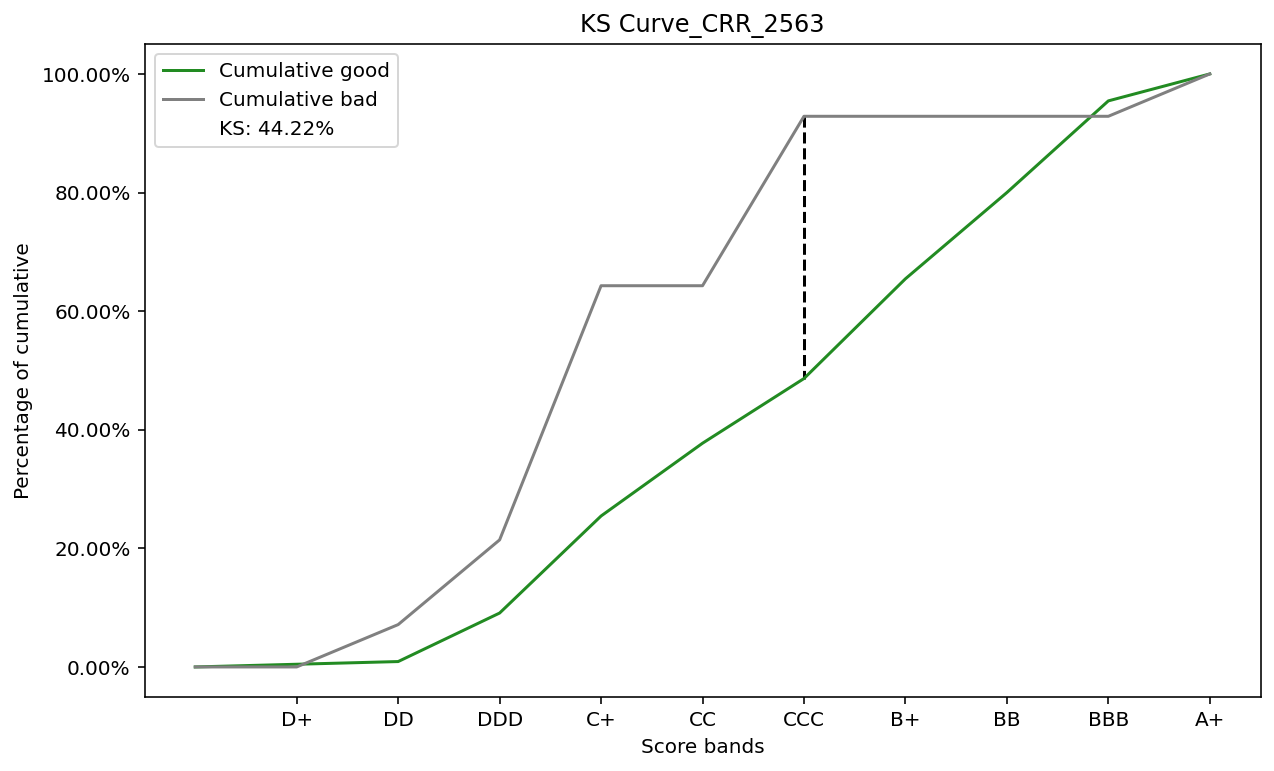

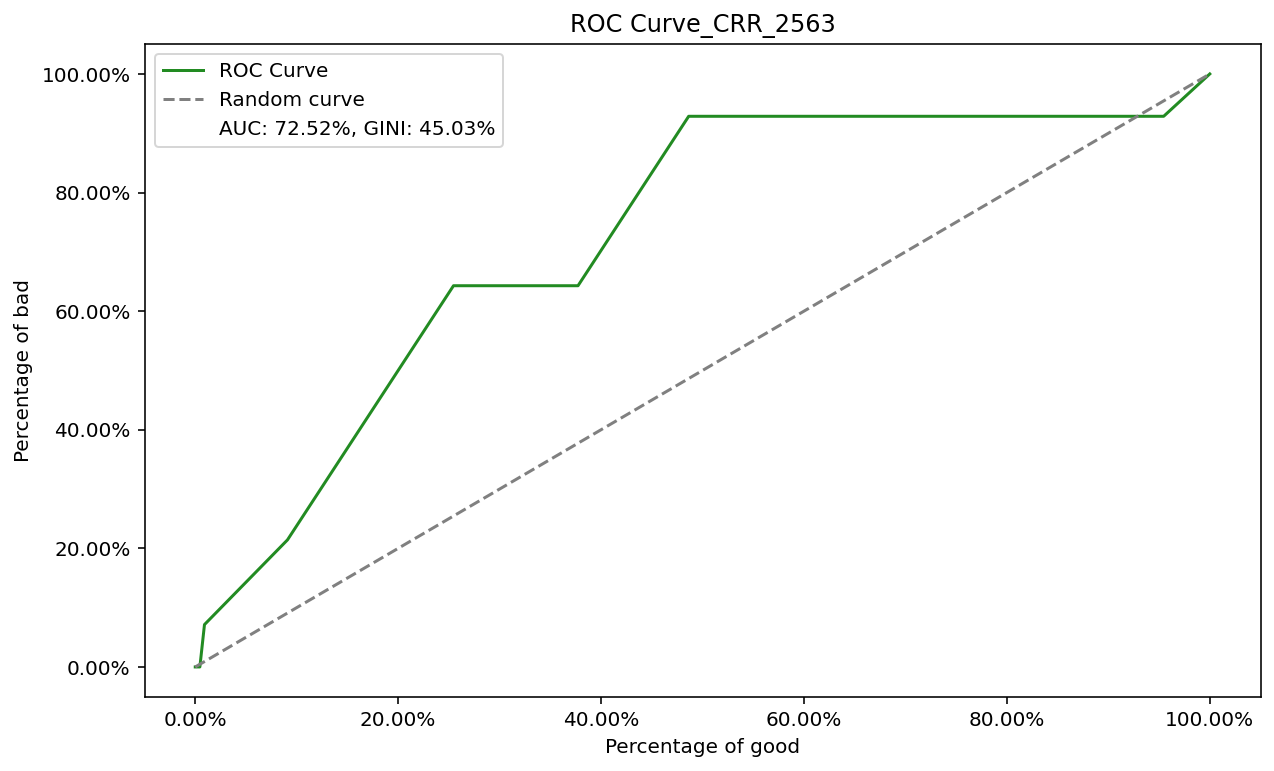

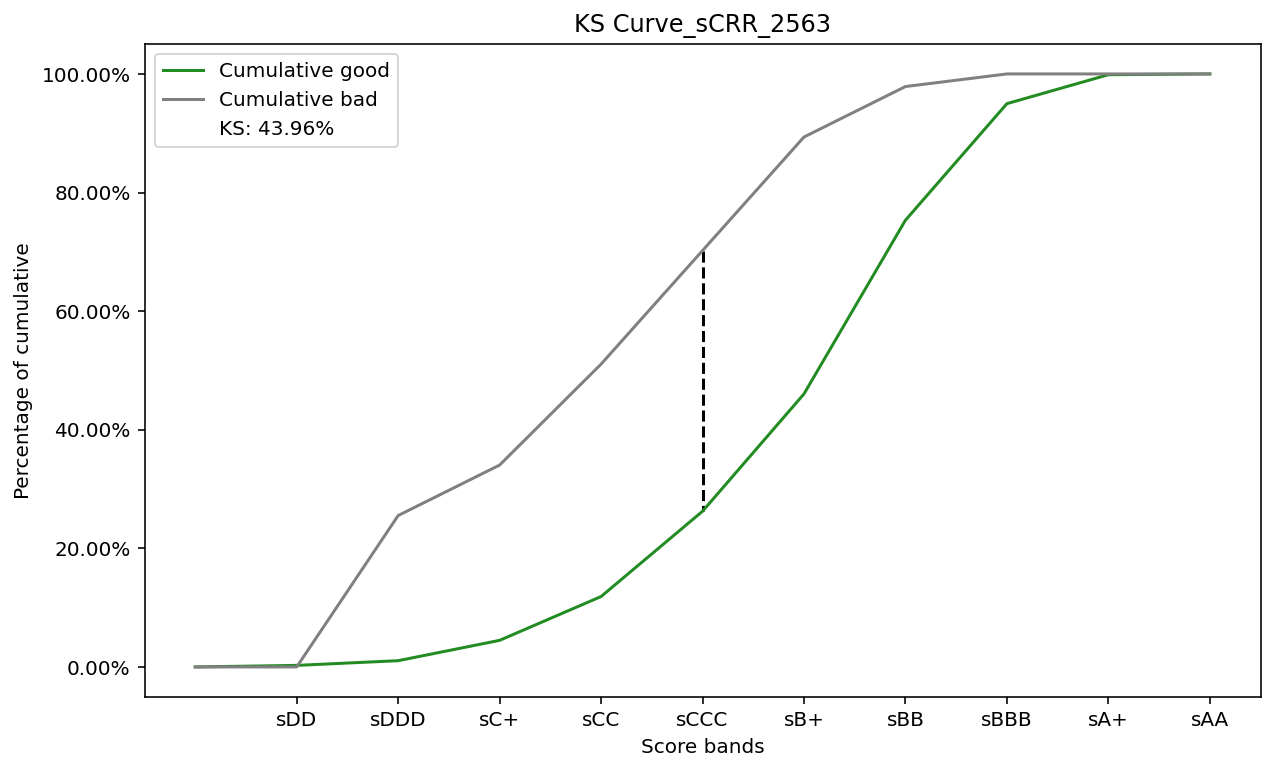

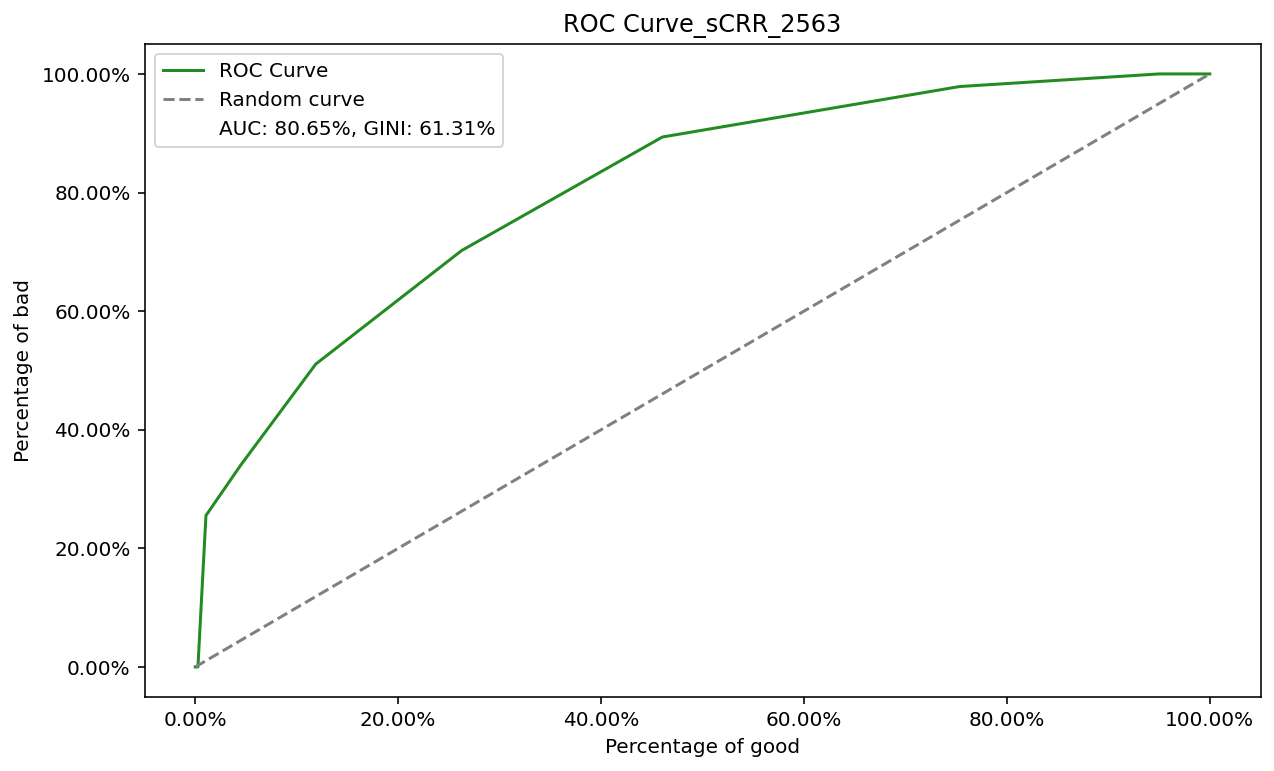

In [83]:
### CRR
CRR_2563 = pd.pivot_table(df_CRR_2563, values='CUST_ID', index=['Grade'],columns=['FlagGB'], aggfunc='count')
CRR_2563.reset_index(inplace=True)
CRR_2563.set_index([pd.Index([0,3,2,1,6,5,4,9,8,7])],inplace = True)
CRR_2563.fillna(0,inplace=True)
CRR_2563 =  validate(CRR_2563)
KS_CRR_2563 = plot_KS(CRR_2563)
AUC_GINI_CRR_2563 = plot_AUC_GINI(CRR_2563)
### For export Graph
export_Graph(KS_CRR_2563)
export_Graph(AUC_GINI_CRR_2563)
### Small CRR
sCRR_2563 = pd.pivot_table(df_sCRR_2563, values='CUST_ID', index=['Grade'],columns=['FlagGB'], aggfunc='count')
sCRR_2563.reset_index(inplace=True)
sCRR_2563.set_index([pd.Index([1,0,4,3,2,7,6,5,9,8])],inplace = True)
sCRR_2563.fillna(0,inplace=True)
sCRR_2563 =  validate(sCRR_2563)
KS_sCRR_2563 = plot_KS(sCRR_2563)
AUC_GINI_sCRR_2563 = plot_AUC_GINI(sCRR_2563)
### For export Graph
export_Graph(KS_sCRR_2563)
export_Graph(AUC_GINI_sCRR_2563)

## prepare_data_2564 

In [ ]:
### prepare 
data = pd.read_csv(input_data+'CRR2564.csv',encoding='UTF-8')
data['เลขที่ CIF'] = data['เลขที่ CIF'].str.strip()
data.dropna(subset=['เลขที่ CIF'],inplace=True)
data.rename(columns={"เลขที่ CIF": "Customer Number"},inplace=True)
### fitter not number
data_main = data[data['Customer Number'].str.contains(r'[0-9]')]
data_main = data_main[data_main['Customer Number'] != 'G514300']
### convert type object to int
data_main['Customer Number'] = data_main['Customer Number'].astype(np.int64)
df = data_main.merge(mapping,on='Customer Number',how='left')
df = df.dropna(subset=['USER2'])
df = df.drop_duplicates(subset=['Customer Number'])
df = df.dropna(subset=['Grade'])
df = df[~(df['Grade']=='-')]
df.reset_index(drop=True)
### map data
df = data_main.merge(mapping,on='Customer Number',how='left')
df = df.dropna(subset=['USER2'])
df = df.drop_duplicates(subset=['Customer Number'])
df = df.dropna(subset=['Grade'])
df = df[~(df['Grade']=='-')]
df.reset_index(drop=True)
### Preparedata_Grade
#df['Grade'].unique()
grade_Fix(df)
#df.groupby(['Grade']).sum()
### Define Good_Bad
df_2564 = define_Good_Bad(df)
### backup_data
backupdata(df_2564,'2564')
### Medium && Large CRR
df_CRR_2564 = df_2564[~df_2564['Grade'].str.contains('[s,S]')]
df_CRR_2564[['Grade','Good','Bad']].groupby(['Grade']).sum()
### Small CRR
df_sCRR_2564 = df_2564[df_2564['Grade'].str.contains('[s,S]')]
df_sCRR_2564[['Grade','Good','Bad']].groupby(['Grade']).sum()

backup data file '2564' done! 



,Good,Bad
Grade,,
sA+,16,0
sB+,67,0
sBB,83,0
sBBB,56,0
sC+,27,1
sCC,46,0
sCCC,37,0
sDD,1,1
sDDD,12,0


## prepare_data_2565 

## plot graph

In [ ]:
##As_of_2563
##CRR
CRR_2563 =  validate(df_CRR_2563)
KS_CRR_2563 = plot_KS(CRR_2563)
export_Graph(KS_CRR_2563)
AUC_GINI_CRR_2563 = plot_AUC_GINI(CRR_2563)
export_Graph(AUC_GINI_CRR_2563)
##sCRR
sCRR_2563 =  validate(df_sCRR_2563)
KS_sCRR_2563 = plot_KS(sCRR_2563)
export_Graph(KS_sCRR_2563)
AUC_GINI_sCRR_2563 = plot_AUC_GINI(sCRR_2563)
export_Graph(AUC_GINI_sCRR_2563)
# ##As_of_2564
# CRR_2564 =  validate(df_CRR_2564)
# KS_CRR_2564 = plot_KS(CRR_2564)
# export_Graph(KS_CRR_2564)
# AUC_GINI_CRR_2564 = plot_AUC_GINI(CRR_2564)
# export_Graph(AUC_GINI_CRR_2564)
# ##sCRR
# sCRR_2564 =  validate(df_sCRR_2564)
# KS_sCRR_2564 = plot_KS(sCRR_2564)
# export_Graph(KS_sCRR_2564)
# AUC_GINI_sCRR_2564 = plot_AUC_GINI(sCRR_2564)
# export_Graph(AUC_GINI_sCRR_2564)